#### We are going to use Flickr8-dataset. The dataset is available on kaggle here: https://www.kaggle.com/datasets/adityajn105/flickr8k?resource=download

#### **Preprocess data**

In [97]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.vgg16 import preprocess_input
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Configuration
image_folder = "Flickr8_data/Images"
caption_file = "Flickr8_data/captions.txt"
vocab_size = 10000  # Adjust based on your specific needs

# Load Captions
def load_captions(filename):
    with open(filename, 'r') as file:
        text = file.read()
    captions = {}
    for line in text.strip().split('\n')[1:]:
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        image_id = image_id.split('.')[0]  # Remove extension if present
        image_desc = ' '.join(image_desc)
        captions[image_id] = image_desc
    return captions

# Load and Preprocess Images
def load_images(image_folder, image_ids):
    images = {}
    for image_id in tqdm(image_ids, desc="Loading Images"):
        image_path = os.path.join(image_folder, f"{image_id}.jpg")
        try:
            image = load_img(image_path, target_size=(224, 224))
            image = img_to_array(image)
            image = preprocess_input(image)
            images[image_id] = image
        except FileNotFoundError:
            print(f"Error loading image '{image_path}': File not found.")
    return images

# Prepare Captions for Training
def prepare_captions(captions, vocab_size):
    tokenizer = Tokenizer(num_words=vocab_size, oov_token="<unk>")
    tokenizer.fit_on_texts(captions.values())
    sequences = tokenizer.texts_to_sequences(captions.values())
    max_length = max(len(seq) for seq in sequences)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
    return padded_sequences, tokenizer, max_length

def prepare_data_for_training(captions_padded, vocab_size, max_length):
    # Slice captions to align with model's expected input length
    X_captions = captions_padded[:, :max_length]  # Ensure length matches the model's expected input
    next_words = captions_padded[:, 1:max_length+1]  # Ensure the labels are correctly aligned

    # Convert next_words to categorical data if using categorical_crossentropy
    #y = tf.keras.utils.to_categorical(next_words, num_classes=vocab_size)
    y = np.array([tf.keras.utils.to_categorical(captions_padded[i, 1], num_classes=vocab_size) for i in range(len(captions_padded))])
    return X_captions, y

# Main Data Preparation Function
def prepare_data(image_folder, caption_file, vocab_size, max_images):
    # Load data
    captions = load_captions(caption_file)
    image_ids = list(captions.keys())[:max_images]
    images = load_images(image_folder, image_ids)

    captions = {id: captions[id] for id in image_ids if id in images}

    # Prepare captions
    padded_captions, tokenizer, max_length = prepare_captions(captions, vocab_size)

    # Split data
    train_ids, test_ids = train_test_split(image_ids, test_size=0.2, random_state=42)

    # Convert data for model
    train_images = np.array([images[id] for id in train_ids if id in images])
    train_captions = np.array([padded_captions[i] for i, id in enumerate(train_ids) if id in captions])
    train_y = np.roll(train_captions, -1, axis=1)
    train_y[:, -1] = 0  # Set last element to 0 because there is no next word

    test_images = np.array([images[id] for id in test_ids if id in images])
    test_captions = np.array([padded_captions[i] for i, id in enumerate(test_ids) if id in captions])
    test_y = np.roll(test_captions, -1, axis=1)
    test_y[:, -1] = 0  # Set last element to 0 similarly

    train_captions, train_y = prepare_data_for_training(train_captions, vocab_size,max_length)
    test_captions, test_y = prepare_data_for_training(test_captions, vocab_size,max_length)

    #return (train_images, train_captions, train_y), (test_images, test_captions, test_y), max_length, tokenizer
    return (train_images, train_captions, train_y), test_ids, max_length, tokenizer

# Usage
(train_images, train_captions, train_y), test_ids, max_length, tokenizer = prepare_data(image_folder, caption_file, vocab_size,max_images=500)


Loading Images: 100%|██████████| 500/500 [00:05<00:00, 86.37it/s] 


#### **Here we are going to create a model. The model has an input shape of 224,224,3, and will use the weights from imagenet.**

#### **This model is then connected to a LSTM, for image captioning.**



In [98]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Concatenate, TimeDistributed, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

def create_model(vocab_size, max_length):
    
    vgg = VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
    vgg.trainable = False  
    image_input = Input(shape=(224, 224, 3))
    features = vgg(image_input)
    features = tf.keras.layers.GlobalAveragePooling2D()(features)
    image_dense = Dense(256*2, activation='tanh')(features)
    image_dense = Dropout(0.5)(image_dense)
    
    # Caption model
    caption_input = Input(shape=(max_length,))
    caption_embedding = Embedding(input_dim=vocab_size, output_dim=256,input_length=max_length)(caption_input)
    caption_lstm = LSTM(256*2)(caption_embedding)
    
    # Combine image and caption information
    decoder_input = Concatenate()([image_dense, caption_lstm])
    outputs = Dense(vocab_size, activation='softmax')(decoder_input)
    caption_lstm = Dropout(0.5)(caption_lstm)
    
    
    # Final model
    model = Model(inputs=[image_input, caption_input], outputs=outputs)
    #model.compile(loss='categorical_crossentropy', optimizer='adam')
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001),metrics='accuracy') 
    
    return model


#### The model architecture consists of 2 branches: first for processing images using VGG16 and second for processing captions using LSTM. >>>> The output embeddings from both branches are concatenated. >>> The concatenated embeddings are passed through a dense layer with softmax activation to predict the next word in the caption. >>> The model is compiled using categorical crossentropy loss and the Adam optimizer.

In [99]:
# Vocabulary size
#vocab_size = len(tokenizer.word_index) + 1  # Add 1 for the <unk> token

# Maximum length of sequences
#max_length = max(len(seq) for seq in captions_seq.values())

model = create_model(vocab_size, max_length)
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_53 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, 7, 7, 512)            1471468   ['input_53[0][0]']            
                                                          8                                       
                                                                                                  
 global_average_pooling2d_1  (None, 512)                  0         ['vgg16[0][0]']               
 7 (GlobalAveragePooling2D)                                                                       
                                                                                           

In [100]:
def prepare_data_for_training(captions_padded, tokenizer):
    # Create training sequences and the next word as label for each timestep
    X_captions = captions_padded[:, :-1]  # All but the last word for input
    next_words = captions_padded[:, 1:]  # All but the first word for output labels

    # Convert next_words to one-hot encoded format
    y = tf.keras.utils.to_categorical(next_words, num_classes=vocab_size)
    return X_captions, y

model.fit([train_images, train_captions], train_y, epochs=10, batch_size=1)

Epoch 1/10
400/400 [==============================] - 103s 251ms/step - loss: 7.3961 - accuracy: 0.0375
Epoch 2/10
400/400 [==============================] - 123s 308ms/step - loss: 6.2054 - accuracy: 0.0250
Epoch 3/10
400/400 [==============================] - 98s 245ms/step - loss: 6.1344 - accuracy: 0.0500
Epoch 4/10
400/400 [==============================] - 92s 228ms/step - loss: 5.9018 - accuracy: 0.0650
Epoch 5/10
400/400 [==============================] - 75s 187ms/step - loss: 5.6113 - accuracy: 0.0700
Epoch 6/10
400/400 [==============================] - 77s 194ms/step - loss: 5.4712 - accuracy: 0.0850
Epoch 7/10
400/400 [==============================] - 101s 252ms/step - loss: 5.0579 - accuracy: 0.0975
Epoch 8/10
400/400 [==============================] - 131s 328ms/step - loss: 4.9544 - accuracy: 0.1050
Epoch 9/10
400/400 [==============================] - 139s 346ms/step - loss: 4.5136 - accuracy: 0.1325
Epoch 10/10
400/400 [==============================] - 118s 295ms/st

In [101]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt 

def load_test_images(image_folder, image_ids):
    images = {}
    for image_id in tqdm(image_ids, desc="Loading Test Images"):
        image_path = os.path.join(image_folder, f"{image_id}.jpg")
        try:
            image = load_img(image_path, target_size=(224, 224))
            image = img_to_array(image)
            image = preprocess_input(image)
            images[image_id] = image
        except FileNotFoundError:
            print(f"Error loading image '{image_path}': File not found.")
    return images

# Generate a caption for an image
def generate_caption(model, image, tokenizer, max_length):
    in_text = '<start>'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat)
        if word is None or word == '<end>':
            break
        in_text += ' ' + word
    return in_text

# Generate captions for the test set
def generate_captions_for_test_set(test_images, test_ids, model, tokenizer, max_length):
    captions = {}
    for image_id in test_ids:
        image = test_images[image_id]
        image = np.expand_dims(image, axis=0)  # Ensure the image has the correct shape
        caption = generate_caption(model, image, tokenizer, max_length)
        captions[image_id] = caption
    return captions

# Plot images with captions
def plot_images_with_captions(test_images, test_captions, num_images=5):
    image_ids = list(test_images.keys())[:num_images]

    plt.figure(figsize=(15, 10))
    
    for i, image_id in enumerate(image_ids):
        image = test_images[image_id]
        caption = test_captions[image_id]
        
        plt.subplot(num_images // 2 + 1, 2, i + 1)
        plt.imshow(image)
        plt.title(caption)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

#test_ids = ["test_id1", "test_id2", ...]  # Provide your test image IDs
test = test_ids[:2]
test_images = load_test_images(image_folder, test)


test_captions = generate_captions_for_test_set(test_images, test, model, tokenizer, max_length)

Loading Test Images: 100%|██████████| 2/2 [00:00<00:00, 73.60it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


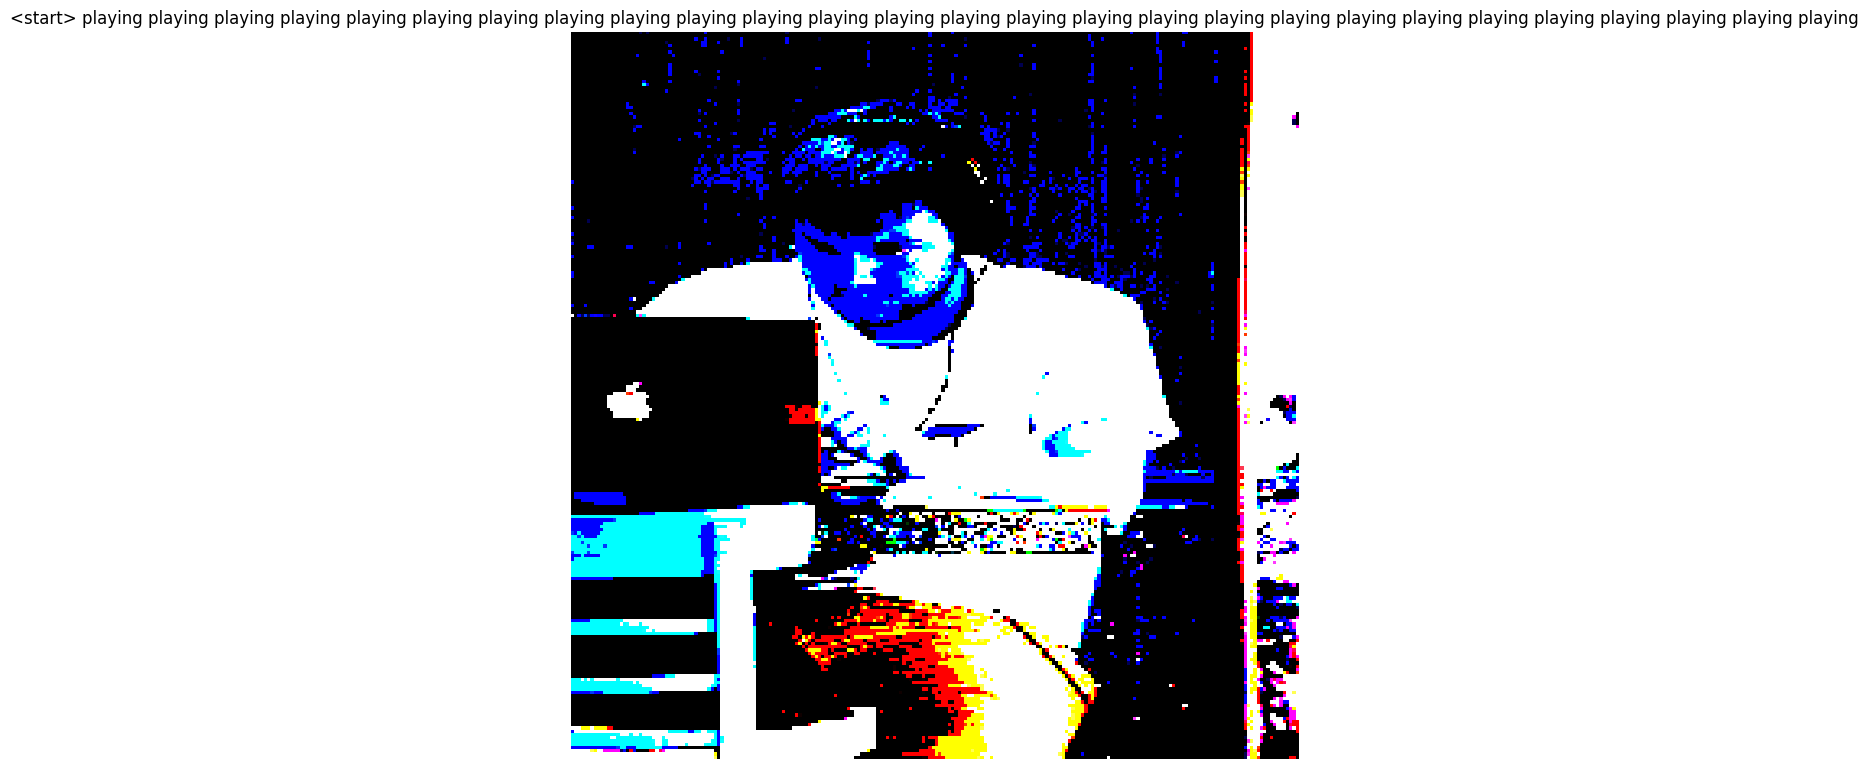

In [105]:
plot_images_with_captions(test_images, test_captions, num_images=1)

In [103]:
test_captions

{'1379026456_153fd8b51b': '<start> playing playing playing playing playing playing playing playing playing playing playing playing playing playing playing playing playing playing playing playing playing playing playing playing playing playing playing',
 '1089755335_0bfbfd30e6': '<start> playing playing playing playing playing playing playing playing playing playing playing playing playing playing playing playing playing playing playing playing playing playing playing playing playing playing playing'}

In [56]:
tokenizer.word_index

{'<unk>': 1,
 'a': 2,
 'the': 3,
 'in': 4,
 'on': 5,
 'is': 6,
 'and': 7,
 'with': 8,
 'dog': 9,
 'of': 10,
 'man': 11,
 'water': 12,
 'at': 13,
 'young': 14,
 'boy': 15,
 'are': 16,
 'dogs': 17,
 'white': 18,
 'people': 19,
 'running': 20,
 'girl': 21,
 'wearing': 22,
 'blue': 23,
 'black': 24,
 'playing': 25,
 'little': 26,
 'sitting': 27,
 'brown': 28,
 'field': 29,
 'woman': 30,
 'an': 31,
 'to': 32,
 'shirt': 33,
 'while': 34,
 'large': 35,
 'through': 36,
 'down': 37,
 'into': 38,
 'child': 39,
 'red': 40,
 'toy': 41,
 'beach': 42,
 'jumping': 43,
 'pool': 44,
 'up': 45,
 'grass': 46,
 'green': 47,
 'rock': 48,
 'holding': 49,
 'hat': 50,
 'off': 51,
 'air': 52,
 'small': 53,
 'near': 54,
 'standing': 55,
 'front': 56,
 'climbing': 57,
 'sit': 58,
 'walking': 59,
 'camera': 60,
 'outside': 61,
 'wall': 62,
 'snow': 63,
 'ball': 64,
 'men': 65,
 'by': 66,
 'grassy': 67,
 'another': 68,
 'sits': 69,
 'his': 70,
 'mountain': 71,
 'each': 72,
 'other': 73,
 'one': 74,
 'side': 75,
 '